In [1]:
from __future__ import print_function

# Standard modules
import os
import pickle
import numpy as np
import numpy.linalg as npl
import nibabel as nib

# Dipy modules
import dipy.viz.regtools as rt
import dipy.align.imwarp as imwarp
from dipy.align import VerbosityLevels
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import regtransforms

# EPI correction (new) modules
import dipy.correct.gradients as gr
from dipy.correct.splines import CubicSplineField
from dipy.correct.epicor import (OppositeBlips_CC_Motion,
                                 OffResonanceFieldEstimator)
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
floating = np.float64

Populating the interactive namespace from numpy and matplotlib


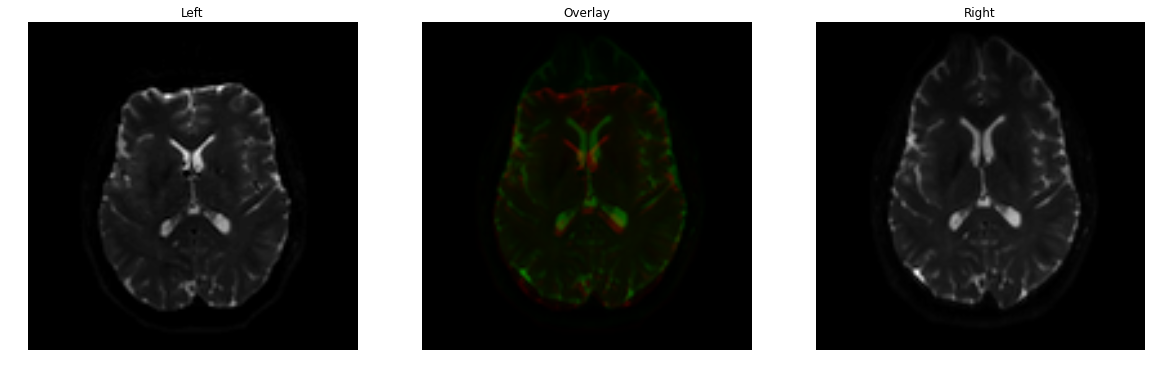

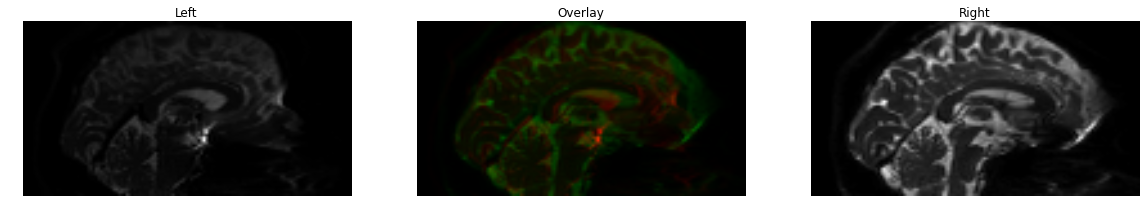

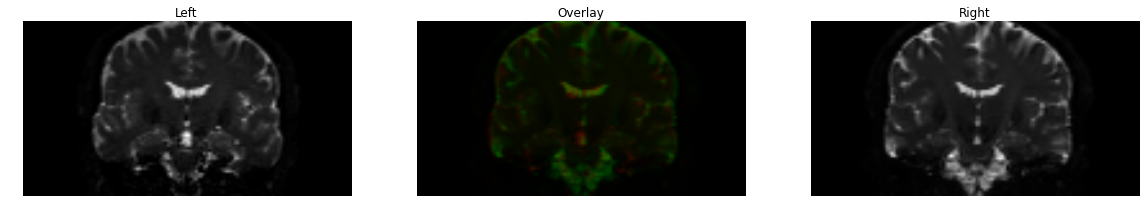

In [2]:
# Load data
data_dir = '/home/omar/data/topup_example/'
up_fname = data_dir + "b0_blipup.nii"
down_fname = data_dir + "b0_blipdown.nii"

up_nib = nib.load(up_fname)
up_affine = up_nib.get_affine()
up = up_nib.get_data().squeeze().astype(np.float64)

down_nib = nib.load(down_fname)
down_affine = down_nib.get_affine()
down = down_nib.get_data().squeeze().astype(np.float64)
rt.overlay_slices(down, up, slice_type=2);
rt.overlay_slices(down, up, slice_type=0);
rt.overlay_slices(down, up, slice_type=1);

In [11]:
# Get direction and spacings
pedir_up = np.array((0,1,0), dtype=np.float64)
pedir_down = np.array((0,-1,0), dtype=np.float64)

dir_up, spacings_up = imwarp.get_direction_and_spacings(up_affine, 3)
dir_down, spacings_down = imwarp.get_direction_and_spacings(down_affine, 3)
spacings = spacings_down.copy()

# Configure and run orfield estimation
radius = 4
distortion_model = OppositeBlips_CC_Motion(radius=radius)
level_iters = [100, 100, 100, 100, 50, 50, 50]
lambdas = np.array([0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.005])*((radius+1)**3)
fwhm = np.array([8, 6, 4, 3, 2, 1, 0])
step_lengths = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*2
warp_res = np.array([20, 16, 14, 12, 6, 4, 4], dtype=np.float64)
subsampling = [2, 2, 2, 2, 1, 1, 1]

estimator = OffResonanceFieldEstimator(distortion_model,
                                       level_iters=level_iters,
                                       lambdas=lambdas,
                                       fwhm=fwhm,
                                       step_lengths=step_lengths,
                                       warp_res=warp_res,
                                       subsampling=subsampling)

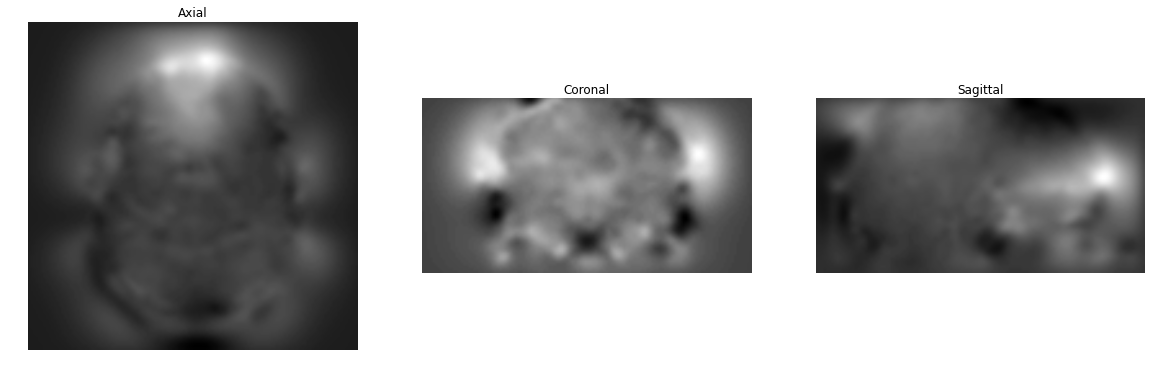

In [17]:
orfield_coef_fname = 'orfield_coef_rigid_multires.p'
orfield = None
if os.path.isfile(orfield_coef_fname):
    coef, R = pickle.load(open(orfield_coef_fname, 'r'))
    kspacing = np.round(estimator.warp_res[-1]/spacings)
    kspacing = kspacing.astype(np.int32)
    kspacing[kspacing < 1] = 1
    orfield = CubicSplineField(up.shape, kspacing)
    orfield.copy_coefficients(coef)
else:
    orfield, R = estimator.optimize_with_ss_motion(down, down_affine, pedir_down, up, up_affine, pedir_up, spacings)
    pickle.dump(tuple([np.array(orfield.coef), R]), open(orfield_coef_fname, 'w'))
b  = np.array(orfield.get_volume((0, 0, 0)))
rt.plot_slices(b);

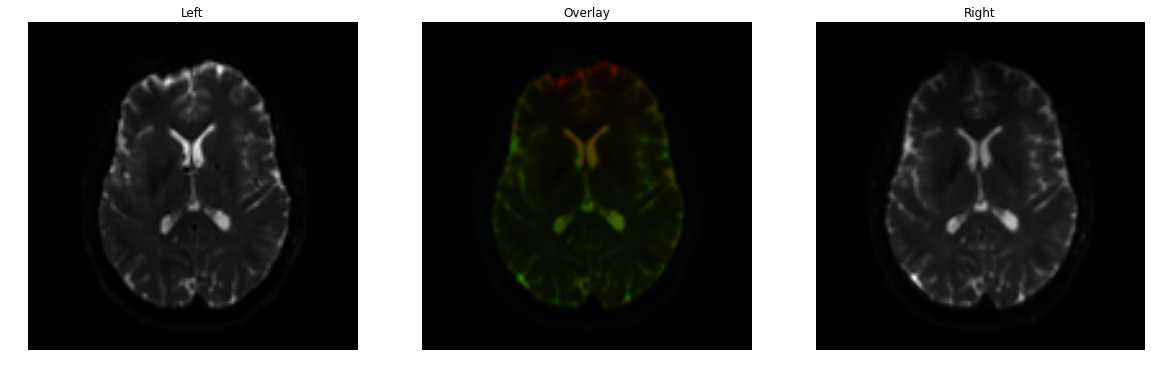

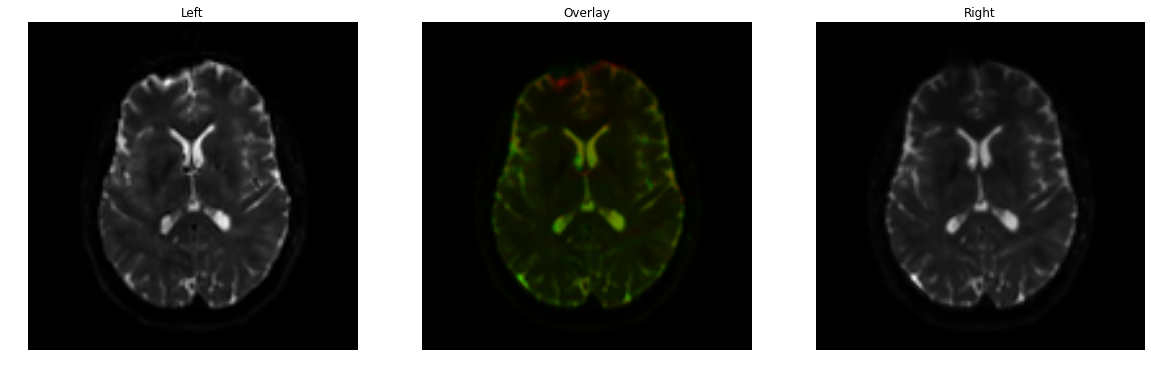

In [18]:
# Warp up
shape = np.array(down.shape, dtype=np.int32)
Ain = None
Aout = npl.inv(up_affine).dot(down_affine).dot(R)
Adisp = None
w_up, _m = gr.warp_with_orfield(up, b, pedir_up, Ain, Aout, Adisp, shape)

# Warp down
Ain = None
Aout = npl.inv(down_affine).dot(down_affine)
Adisp = None
w_down, _m = gr.warp_with_orfield(down, b, pedir_down, Ain, Aout, Adisp, shape)

rt.overlay_slices(w_down, w_up, slice_type=2);

# Compute Jacobians
gb = np.zeros(shape=b.shape + (3,), dtype=np.float64)
gb[...,0] = orfield.get_volume((1,0,0))
gb[...,1] = orfield.get_volume((0,1,0))
gb[...,2] = orfield.get_volume((0,0,1))
Jdown = gb[...,0]*pedir_down[0] + gb[...,1]*pedir_down[1] + gb[...,2]*pedir_down[2] + 1
Jup =   gb[...,0]*pedir_up[0]   + gb[...,1]*pedir_up[1]   + gb[...,2]*pedir_up[2]   + 1

# Discard negative Jacobians ?
#Jdown[Jdown<0] = 0
#Jup[Jup<0] = 0

rt.overlay_slices(w_down*Jdown, w_up*Jup, slice_type=2);

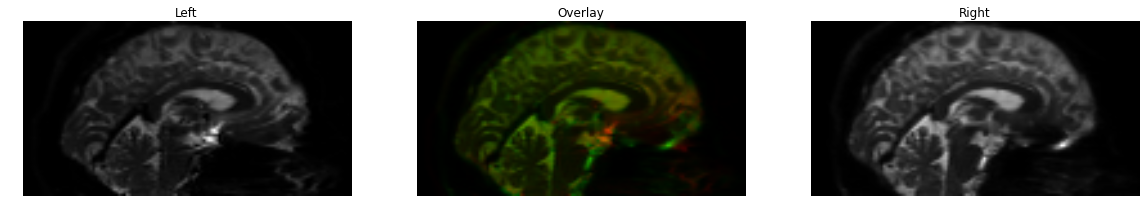

In [14]:
rt.overlay_slices(w_down*Jdown, w_up*Jup, slice_type=0);

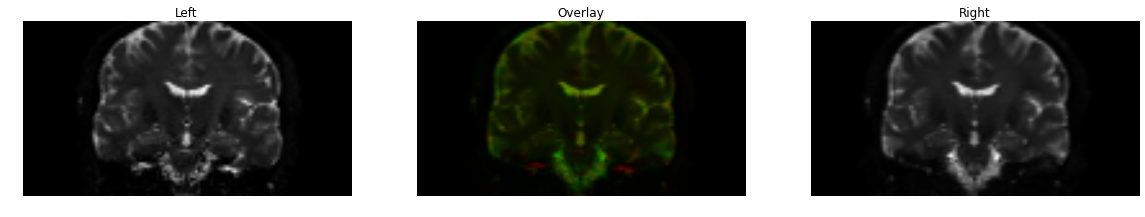

In [15]:
rt.overlay_slices(w_down*Jdown, w_up*Jup, slice_type=1);

In [19]:
R

array([[ 0.99999195,  0.00325439,  0.00234786,  0.88837084],
       [-0.00325961,  0.99999222,  0.00222243,  0.29104416],
       [-0.00234061, -0.00223007,  0.99999477,  0.26794608],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])